<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Tuning ANN-parameters for your Vespa application

<div class="alert alert-info">
    You probably want to be somewhat familiar with Vespa and ANN search before going through this example.<br>Recommended background reading: 
    <ul>
        <li><a href="https://docs.vespa.ai/en/nearest-neighbor-search-guide.html">Vespa nearest neighbor search - a practical guide</a></li>
        <li><a href="https://blog.vespa.ai/approximate-nearest-neighbor-search-in-vespa-part-1/">ANN Search in Vespa</a></li>
        <li><a href="https://blog.vespa.ai/constrained-approximate-nearest-neighbor-search/">Query Time Constrained Approximate Nearest Neighbor Search</a></li>
        <li><a href="https://blog.vespa.ai/additions-to-hnsw/">Additions to HNSW in Vespa: ACORN-1 and Adaptive Beam Search</a></li>
        <li><a href="https://blog.vespa.ai/tweaking-ann-parameters/">A Short Guide to Tweaking Vespa's ANN Parameters</a></li>
    </ul>
</div>    

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vespa-engine/pyvespa/blob/master/docs/sphinx/source/ann-parameter-tuning-vespa-cloud.ipynb)

Approximate Nearest Neighbor (ANN) search is a powerful way to make vector search scalable and efficient. In Vespa, this is implemented by building HNSW graphs for embedding fields.

## Why different strategies are needed

For a search that uses _only_ vector similarity for retrieval, this works very well for all cases, as you can just query the HNSW index and get (enough) relevant results back very fast.

However, most Vespa applications are more complex, and implement some sort of hybrid retrieval strategy, often combining vector similarity with filtering on metadata fields and/or lexical matching (weakAnd).

In this case, it is not obvious whether applying the filter first and doing an exact search will be more efficient than doing HNSW (in different variations, as we will get back to). 

The _hit-ratio_ of the filter for a given query will determine what is the most efficient strategy for the given query. 

Therefore, while (we) Vespa has chosen the default values of the parameters in a way that works well in most use cases, one usually can benefit from further tuning these parameters for each application / use case. 

This notebook will demonstrate how this tuning can be done with the recent addition of the `VespaNNParameterOptimizer` class. 

Hopefully, by stepping through this notebook, you will have learned how you can apply the same steps to tune _your_ Vespa application (ANN configuration parameters) to get faster search responses while still maintaining acceptable recall. 

## A short note on `recall`

It is worth noting that our definition of `recall` in the context of tuning NN-parameters differs slightly from the `recall` definition used in eg. `VespaMatchEvaluator` (see https://vespa-engine.github.io/pyvespa/evaluating-vespa-application-cloud.html).

When optimizing NN-parameters, the recall will be the fraction of top K (targetHits) documents scored by exact distance that are also retrieved by the given strategy. 

This approach does not need a set of `relevant_docs`,in contrast to the `VespaMatchEvaluator`, which calculates the recall as fraction of relevant documents that are retrieved.

The good news is that a set of representative queries is all we need to tune these parameters to find the values that ensures a fast response time _and_ maintains acceptable recall across your provided queries. 

## The different strategies

With the recent addition of ACORN-1 and Adaptive Beam Search to Vespa's ANN implementation, Vespa now switches between one of the following three strategies:

1. HNSW Search with Pre-Filtering when the percentage of filtered-out documents is low,
2. HNSW Search with Pre-Filtering: Filter First/ACORN-1 when the percentage of filtered-out documents is high,
3. Exact Nearest-Neighbor Search when the percentage of filtered-out documents approaches 100%.

_When_ to switch between these three strategies is determined by a combination of a per-query internally calculated `hit-ratio` and the parameters below:

- `filter-first-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if the filter is checked before computing a distance (filter-first heuristic) while searching the HNSW graph for approximate neighbors with filtering. This improves the response time at low hit ratios but causes a dip in recall. The heuristic is used when the filter hit ratio of the query is less than this threshold. The default value is 0.3.
- `approximate-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if a query with an approximate nearestNeighbor operator combined with filters is evaluated by searching the HNSW graph for approximate neighbors with filtering, or performing an exact nearest neighbor search with pre-filtering. The fallback to exact search is chosen when the filter hit ratio of the query is less than this threshold. The default value is 0.02.
- `post-filter-threshold`: Threshold value (in the range [0.0, 1.0]) deciding if a query with an approximate nearestNeighbor operator combined with filters is evaluated using post-filtering instead of the default filtering. Post-filtering is chosen when the filter hit ratio for the query is larger than this threshold. The default value is 1.0, which disables post-filtering. 

<div class="alert alert-info">
    This is a bit simplified as some of the hit ratios referred to in the previous section may be an estimated hit ratio.
</div>  

The function below might make it easier to see which strategy is chosen for an ANN-query with a given hit ratio.

In [ ]:
def determine_ann_strategy(
    hit_ratio: float,
    filter_first_threshold: float = 0.3,
    approximate_threshold: float = 0.02,
    post_filter_threshold: float = 1.0,
) -> str:
    """
    Determine the the chosen NN-strategy based on hit ratio and thresholds.

    Args:
        hit_ratio: The hit ratio for the current query.
        filter_first_threshold: The threshold below which filter-first heuristic is preferred.
        approximate_threshold: The threshold below which approximate search is preferred.
        post_filter_threshold: The threshold above which post-filtering is preferred.
    Returns:
        A string indicating the recommended search strategy.
    """
    # 1. Check if hit ratio is too low for approximate search
    if hit_ratio < approximate_threshold:
        return "Exact Search"

    # 2. Check post-filtering
    if hit_ratio >= post_filter_threshold:
        return "Post-Filtering"

    # 3. Check if filter-first heuristic should be used
    if hit_ratio < filter_first_threshold:
        return "Filter-First/ACORN-1"

    # 4. Default: standard HNSW with pre-filtering
    return "HNSW with Pre-Filtering"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_ann_strategy_selection(
    title: str = "ANN Strategy Selection Based on Hit Ratio",
    filter_first_threshold: float = 0.3,
    approximate_threshold: float = 0.02,
    post_filter_threshold: float = 1.0,
    figsize: tuple = (14, 6),
) -> plt.Figure:
    """
    Visualize which ANN strategy is selected across different hit ratios.

    Creates a plot showing the four strategy regions with colored backgrounds
    and annotated threshold values at switching points.

    Args:
        filter_first_threshold: Threshold for filter-first heuristic (default 0.3)
        approximate_threshold: Threshold for exact search fallback (default 0.02)
        post_filter_threshold: Threshold for post-filtering (default 1.0)
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object

    Example:
        >>> fig = plot_ann_strategy_selection(
        ...     filter_first_threshold=0.25,
        ...     approximate_threshold=0.03,
        ...     post_filter_threshold=0.95
        ... )
        >>> plt.show()
    """
    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Generate hit ratios from 0 to 1
    hit_ratios = np.linspace(0, 1, 1000)

    # Define strategy colors with transparency
    colors = {
        "Exact Search": "#9B59B6",
        "Filter-First/ACORN-1": "#27AE60",
        "HNSW with Pre-Filtering": "#3498DB",
        "Post-Filtering": "#E67E22",
    }

    # Calculate strategy for each hit ratio
    strategies = []
    for hr in hit_ratios:
        strategy = determine_ann_strategy(
            hr, filter_first_threshold, approximate_threshold, post_filter_threshold
        )
        strategies.append(strategy)

    # Plot colored regions for each strategy
    current_strategy = strategies[0]
    start_idx = 0

    for i in range(1, len(strategies)):
        if strategies[i] != current_strategy or i == len(strategies) - 1:
            end_idx = i if i < len(strategies) - 1 else i
            ax.axvspan(
                hit_ratios[start_idx] * 100,
                hit_ratios[end_idx] * 100,
                alpha=0.3,
                color=colors[current_strategy],
                label=current_strategy,
            )

            # Add text label in the middle of the region
            mid_point = (hit_ratios[start_idx] + hit_ratios[end_idx]) / 2 * 100
            ax.text(
                mid_point,
                0.5,
                current_strategy,
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color=colors[current_strategy],
                alpha=0.8,
            )

            current_strategy = strategies[i]
            start_idx = i

    # Add vertical lines and annotations at threshold points
    thresholds = [
        (approximate_threshold, "approximateThreshold", "left"),
        (filter_first_threshold, "filterFirstThreshold", "left"),
        (post_filter_threshold, "postFilterThreshold", "right"),
    ]

    for threshold, name, align in thresholds:
        if 0 < threshold <= 1.0:  # Only show if threshold is in valid range
            ax.axvline(
                x=threshold * 100,
                color="#2C3E50",
                linestyle="--",
                linewidth=2,
                alpha=0.8,
                zorder=10,
            )

            # Add annotation with parameter name and value
            y_pos = 0.85 if name == "filterFirstThreshold" else 0.95
            ax.annotate(
                f"{name}\n{threshold:.3f}",
                xy=(threshold * 100, y_pos),
                xytext=(10 if align == "left" else -10, 0),
                textcoords="offset points",
                ha=align,
                va="top",
                fontsize=9,
                fontweight="bold",
                bbox=dict(
                    boxstyle="round,pad=0.5",
                    facecolor="white",
                    edgecolor="#2C3E50",
                    linewidth=1.5,
                    alpha=0.9,
                ),
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=0",
                    lw=1.5,
                    color="#2C3E50",
                ),
            )

    # Set labels and title
    ax.set_xlabel("Hit Ratio (%)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Strategy Selection", fontsize=11, fontweight="bold")
    ax.set_title(
        title,
        fontsize=13,
        fontweight="bold",
        pad=15,
    )

    # Remove y-axis ticks (not meaningful for this visualization)
    ax.set_yticks([])
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)

    # Style the axes
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(labelsize=9)
    ax.grid(True, axis="x", alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    plt.tight_layout()
    return

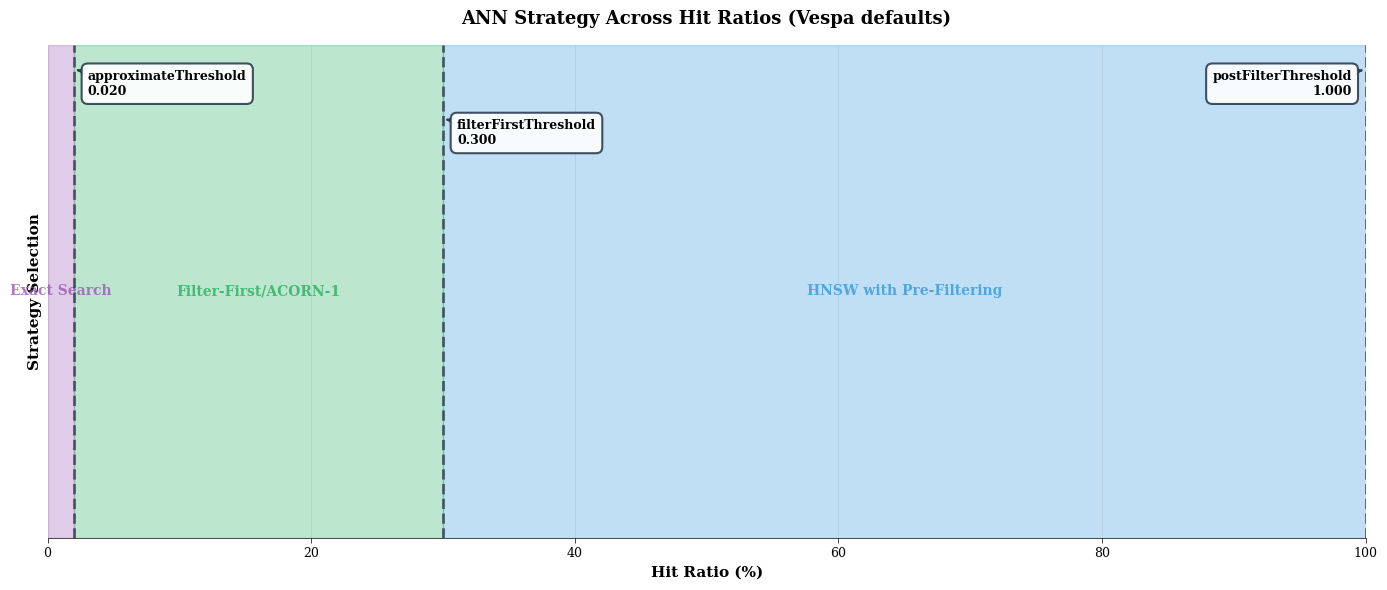

In [69]:
plot_ann_strategy_selection("ANN Strategy Across Hit Ratios (Vespa defaults)")

In addition to the parameters that control which strategy is used, we also have introduced a parameter that controls behavior of the filter-first strategy (when it is applied):

- `filter-first-exploration`: Value (in the range [0.0, 1.0]) specifying how aggressively the filter-first heuristic explores the graph when searching the HNSW graph for approximate neighbors with filtering. A higher value means that the graph is explored more aggressively and improves the recall at the cost of the response time. (Default value is 0.3.)

These parameters can be configured per rank profile or provided as a query parameter, which is passed with the query, and may have a big effect on query performance of queries that combines ANN search with filters.

In this notebook, we will show how to tune these parameters to ensure low response time, without losing much recall compared to exact search.

As a teaser, this is the report we will produce:
 
(Keep reading if you want to understand more)

<img alt="#ANN Optimization report" src="../_static/ann_opt_report.png" style="margin-bottom: 25px;">

<div class="alert alert-info">
    Refer to <a href="https://vespa-engine.github.io/pyvespa/troubleshooting.html">troubleshooting</a>
    for any problem when running this guide.
</div>


**Pre-requisite**: Create a tenant at [cloud.vespa.ai](https://cloud.vespa.ai/), save the tenant name.

Now, let us get started with the practical part. 

## The dataset

The dataset we will use for this notebook is a subset of the [GIST1M-dataset](http://corpus-texmex.irisa.fr/) commonly used for ANN benchmarks.

We have also enriched each document with a `filter`-field of type `array<int>`, that is added to each document, which allows us to construct queries with a predictable hit ratio.

Here is an example document:

```json
{
  "put": "id:test:test::499",
  "fields": {
    "id": 499,
    "filter": [1,10,50,90,95,99],
    "vec_m16": { "values": [0.01345, .., 0.30322] } // 960 float values 
  }
}
```

99% of the documents include the value 1 in the filter field, 90% of the documents include the value 10 in the fitler field and so on.

## Configuring your application

In [1]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "vespa-team"
# Replace with your application name (does not need to exist yet)
application = "anntuning"

## Downloading the dataset

In [2]:
import os
import pathlib
import requests
import matplotlib.pyplot as plt
from vespa.io import VespaResponse

data_base_url = (
    "https://data.vespa-cloud.com/tests/performance/nearest-neighbor/gist-data/"
)

# We use a smaller dataset if the SCALE_DOWN flag is set to True
SCALE_DOWN = False
docs_url = (
    data_base_url + "docs.1k.json" if SCALE_DOWN else data_base_url + "docs.300k.json"
)
query_url = (
    data_base_url + "query_vectors.10.txt"
    if SCALE_DOWN
    else data_base_url + "query_vectors.100.txt"
)
NUMBER_OF_HITS = 10 if SCALE_DOWN else 100

In [3]:
def download_file(url: str, dest_folder: str):
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    if os.path.exists(local_filename):
        print(f"File {local_filename} already exists, skipping download.")
        return local_filename
    print(f"Downloading {url} to {local_filename}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return local_filename


data_path = "ann_test/"
pathlib.Path(data_path).mkdir(parents=True, exist_ok=True)

docs_path = download_file(docs_url, data_path)
query_path = download_file(query_url, data_path)

File ann_test/docs.300k.json already exists, skipping download.
File ann_test/query_vectors.100.txt already exists, skipping download.


## Defining the Vespa application

In [4]:
from vespa.package import (
    ApplicationPackage,
    Schema,
    Document,
    Field,
    RankProfile,
    HNSW,
    DocumentSummary,
    Summary,
)
from vespa.configuration.query_profiles import query_profile, query_profile_type, field


# Define the document with fields
doc = Document(
    fields=[
        Field(
            name="id",
            type="int",
            indexing=["attribute", "summary"],
        ),
        Field(
            name="filter",
            type="array<int>",  # This is our filter field
            indexing=["attribute", "summary"],
            attribute=["fast-search"],
        ),
        Field(
            name="vec_m16",
            type="tensor<float>(x[960])",  # The vector field that we will do ANN search on
            indexing=["attribute", "index", "summary"],
            ann=HNSW(
                distance_metric="euclidean",  # specific to this dataset
                max_links_per_node=16,  #
                neighbors_to_explore_at_insert=500,  # Specifies how many neighbors to explore when inserting a vector in the HNSW graph. The default value in Vespa is 200. This parameter is called efConstruction in the HNSW paper.
            ),
        ),
    ]
)

# Define the rank profile with HNSW tuning parameters
rank_profile = RankProfile(
    name="default",
    inputs=[
        ("query(q_vec)", "tensor<float>(x[960])"),
    ],
    first_phase="closeness(label,nns)",
    # We will tune some of these by overriding them as query parameters later
    rank_properties=[
        ("approximate-threshold", 0.02),
        ("filter-first-threshold", 0.3),
        ("filter-first-exploration", 0.3),
        ("exploration-slack", 0.0),
    ],
)

# Define a minimal document summary to avoid unnecessary data transfer
minimal_summary = DocumentSummary(name="minimal", summary_fields=[Summary(name="id")])

# Create the schema
schema = Schema(
    name=application,
    document=doc,
    rank_profiles=[rank_profile],
    document_summaries=[minimal_summary],
)

# We also define a query profile type for the default query profile to enforce the type of the input tensor
# See https://docs.vespa.ai/en/query-profiles.html#query-profile-types
qp = query_profile(
    id="default",
    type="root",
)

qpt = query_profile_type(
    field(
        name="ranking.features.query(q_vec)",
        type="tensor<float>(x[960])",
    ),
    id="root",
    inherits="native",
)

# Create the application package
app_package = ApplicationPackage(
    name=application, schema=[schema], query_profile_config=[qp, qpt]
)

It is often useful to dump the application package to files for inspection before deploying. 

In [5]:
app_package.to_files("ann_test")

In [6]:
from vespa.deployment import VespaCloud
from vespa.application import Vespa


# Key is only used for CI/CD. Can be removed if logging in interactively
key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly


vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    key_content=key,  # Key is only used for CI/CD. Can be removed if logging in interactively
    application_package=app_package,
)

Setting application...
Running: vespa config set application vespa-team.anntuning.default
Setting target cloud...
Running: vespa config set target cloud

Api-key found for control plane access. Using api-key.


Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes a few minutes until the endpoint is up. (Applications that for example refer to large onnx-models may take a bit longer.)

In [55]:
app: Vespa = vespa_cloud.deploy()

Deployment started in run 21 of dev-aws-us-east-1c for vespa-team.anntuning. This may take a few minutes the first time.
INFO    [12:54:05]  Deploying platform version 8.608.33 and application dev build 19 for dev-aws-us-east-1c of default ...
INFO    [12:54:05]  Using CA signed certificate version 1
INFO    [12:54:05]  Using 1 nodes in container cluster 'anntuning_container'
INFO    [12:54:09]  Using 1 nodes in container cluster 'anntuning_container'
INFO    [12:54:13]  Session 388963 for tenant 'vespa-team' prepared and activated.
INFO    [12:54:13]  ######## Details for all nodes ########
INFO    [12:54:13]  h129348a.dev.us-east-1c.aws.vespa-cloud.net: expected to be UP
INFO    [12:54:13]  --- platform vespa/cloud-tenant-rhel8:8.608.33
INFO    [12:54:13]  --- container on port 4080 has config generation 388960, wanted is 388963
INFO    [12:54:13]  --- metricsproxy-container on port 19092 has config generation 388963, wanted is 388963
INFO    [12:54:13]  h127903b.dev.us-east-1c.aws.v

## Feeding the documents

In [8]:
# Load and feed documents
import json

with open(docs_path, "r") as f:
    docs = json.load(f)

In [9]:
def docs_gen(docs):
    for doc in docs:
        yield {
            "id": str(doc["fields"]["id"]),
            "fields": doc["fields"],
        }

In [ ]:
def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print(
            "Id "
            + id
            + " failed : "
            + response.json["id"]
            + ", Status code: "
            + str(response.status_code)
        )


app.feed_iterable(docs_gen(docs), callback=callback)

Let us run a test query:

In [60]:
resp = app.query(yql="select * from sources * where true limit 1;")
resp.status_code

200

## Constructing queries

As we noted in the introduction, a set of representative queries is all that is needed for tuning ANN parameters. 

When we will compare recall, we will compare against the recall of the exact nearest neighbor search. 

We will use the [Querybuilder API](../query.html#using-the-querybuilder-dsl-api) to construct our queries.

In [13]:
import vespa.querybuilder as qb


def vector_to_query(vec_str: str, filter_value: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_(application)
            .where(
                qb.nearestNeighbor(
                    "vec_m16",
                    "q_vec",
                    annotations={
                        "targetHits": NUMBER_OF_HITS,
                        "approximate": True,
                        "label": "nns",
                    },
                )
                & (qb.QueryField("filter") == filter_value),
            )
        ),
        "hits": 10,
        "presentation.summary": "minimal",
        "timeout": "20s",
        "ranking.features.query(q_vec)": vec_str.strip(),
    }

In [14]:
with open(query_path, "r") as f:
    query_vectors = f.readlines()

# Filter values
filter_percentage = [1, 10, 50, 90, 95, 99]

# We will construct queries for each combination of query vector and filter value
queries = []
# We will also construct a single query per filter value for hit ratio evaluation
# The vector does not affect the hit ratio, so it is overkill to run a query for each vector
# just to determine the hit ratio
hitratio_queries = []  # will only have one query per filter value, choosing the last vector arbitrarily
for filter_value in filter_percentage:
    for vec in query_vectors:
        queries.append(vector_to_query(vec, filter_value))
    hitratio_queries.append(queries[-1])
print(len(queries), len(hitratio_queries))

600 6


Let us now run a test query against our Vespa app.

In [15]:
resp = app.query(queries[0])
resp.json

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 100},
  'coverage': {'coverage': 100,
   'documents': 300000,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'index:anntuning_content/0/546939e42a88c72c83bda0f7',
    'relevance': 0.5514919500458465,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 81360}},
   {'id': 'index:anntuning_content/0/9e6b6ea9df591d1672385a96',
    'relevance': 0.5493186760384602,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 284987}},
   {'id': 'index:anntuning_content/0/33ae6c85ba2829b2be268cd6',
    'relevance': 0.548701224770975,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 238816}},
   {'id': 'index:anntuning_content/0/355d6a2adcb93b4614536016',
    'relevance': 0.5464117465305897,
    'source': 'anntuning_content',
    'fields': {'sddocname': 'anntuning', 'id': 222086}},
   {'id': 

Great, we can see that we get some documents returned. 
The `relevance` score here, is defined by the `closeness(label, nns)`-expression we defined in our rank profile when creating our application package.

## Running the Optimizer

Running the optimization is as simple as this:

In [16]:
from vespa.evaluation import VespaNNParameterOptimizer

optimizer = VespaNNParameterOptimizer(
    app=app,
    queries=queries,
    hits=NUMBER_OF_HITS,
    buckets_per_percent=2,
    print_progress=True,
)
report = optimizer.run()

Distributing queries to buckets
  No queries found with filtered-out ratio in [0.25,0.5)
{'buckets_per_percent': 2, 'bucket_interval_width': 0.005, 'non_empty_buckets': [2, 20, 100, 180, 190, 198], 'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99], 'hit_ratios': [0.99, 0.9, 0.5, 0.09999999999999998, 0.050000000000000044, 0.010000000000000009], 'query_distribution': [100, 100, 100, 100, 100, 100]}
Determining suggestion for filterFirstExploration
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.5
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.25
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.375
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.3125
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.28125
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.265625
  Benchmarking: 100.0%
  Computing recall: 100.0%
  Testing 0.2734375
  Benchmarking: 100.0%
 

The returned `report` should give us a lot of valuable info.

In [17]:
report

{'buckets': {'buckets_per_percent': 2,
  'bucket_interval_width': 0.005,
  'non_empty_buckets': [2, 20, 100, 180, 190, 198],
  'filtered_out_ratios': [0.01, 0.1, 0.5, 0.9, 0.95, 0.99],
  'hit_ratios': [0.99,
   0.9,
   0.5,
   0.09999999999999998,
   0.050000000000000044,
   0.010000000000000009],
  'query_distribution': [100, 100, 100, 100, 100, 100]},
 'filterFirstExploration': {'suggestion': 0.27734375,
  'benchmarks': {0.0: [5.586,
    4.270000000000001,
    4.047999999999999,
    3.2960000000000003,
    2.384999999999999,
    1.5119999999999996],
   1.0: [4.193000000000001,
    3.9030000000000014,
    3.9050000000000007,
    4.005000000000001,
    5.777999999999999,
    9.513],
   0.5: [4.010999999999999,
    4.063,
    3.6319999999999983,
    3.8169999999999997,
    4.911999999999999,
    6.581999999999999],
   0.25: [3.948000000000001,
    3.9579999999999997,
    3.653,
    3.8739999999999997,
    2.639000000000001,
    2.095],
   0.375: [3.998000000000001,
    3.993999999999999

## Visualize Optimization Results

Let's vizualize the optimization report to better understand the recommendations.

In [ ]:
from typing import Dict, Any, Tuple


def plot_optimization_report(
    report: Dict[str, Any], figsize: Tuple[int, int] = (18, 14)
) -> plt.Figure:
    """
    Create a comprehensive visualization of the VespaNNParameterOptimizer report.

    This function creates a Tufte-inspired multi-panel plot showing parameters in the
    order they are calculated:
    1. filterFirstExploration (response time + recall)
    2. filterFirstThreshold (response time + recall)
    3. approximateThreshold (response time + recall)
    4. postFilterThreshold (response time + recall)

    Args:
        report: The report dictionary generated by VespaNNParameterOptimizer.run()
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Extract data
    buckets = report["buckets"]
    hit_ratios = np.array(buckets["hit_ratios"]) * 100  # Convert to percentage
    query_distribution = buckets["query_distribution"]

    # Create figure with subplots organized by parameter
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        5, 3, hspace=0.5, wspace=0.3, top=0.94, bottom=0.05, left=0.06, right=0.97
    )

    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Row 0: Query Distribution + Summary Table
    # 1. Query Distribution (top left, spans 2 columns)
    ax_dist = fig.add_subplot(gs[0, 0:2])

    # Use actual hit ratio values for x-positions
    _bars = ax_dist.bar(
        hit_ratios,
        query_distribution,
        width=0.5,
        color="#4A90E2",
        alpha=0.7,
        edgecolor="#2E5C8A",
        linewidth=0.5,
    )

    ax_dist.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_dist.set_ylabel("Number of Queries", fontsize=10, fontweight="bold")
    ax_dist.set_title(
        "Query Distribution Across Hit Ratios", fontsize=11, fontweight="bold", pad=10
    )
    # Set x-axis limits to match other plots (0-100%)
    ax_dist.set_xlim(-2, 102)
    setup_tufte_axes(ax_dist)

    # Add value labels on bars
    for hr, height in zip(hit_ratios, query_distribution):
        if height > 0:  # Only label bars with data
            ax_dist.text(
                hr, height, f"{int(height)}", ha="center", va="bottom", fontsize=8
            )

    # 2. Summary Table (top right)
    ax_summary = fig.add_subplot(gs[0, 2])
    ax_summary.axis("off")

    summary_data = [
        ["Parameter", "Suggested"],
        ["", ""],
        [
            "filterFirstExploration",
            f"{report['filterFirstExploration']['suggestion']:.4f}",
        ],
        ["filterFirstThreshold", f"{report['filterFirstThreshold']['suggestion']:.4f}"],
        ["approximateThreshold", f"{report['approximateThreshold']['suggestion']:.4f}"],
        ["postFilterThreshold", f"{report['postFilterThreshold']['suggestion']:.4f}"],
        ["", ""],
        ["Total Queries", f"{sum(query_distribution)}"],
        ["Number of buckets", f"{len(buckets)}"],
        ["Buckets per %", f"{buckets['buckets_per_percent']}"],
    ]

    table = ax_summary.table(
        cellText=summary_data,
        cellLoc="left",
        loc="center",
        colWidths=[0.65, 0.35],
        bbox=[0, 0, 1, 1],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Style the table
    for i, row in enumerate(summary_data):
        for j in range(len(row)):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor("#34495E")
                cell.set_text_props(weight="bold", color="white", size=8)
            elif i == 1 or i == 6:  # Separator rows
                cell.set_facecolor("#ECF0F1")
                cell.set_height(0.02)
            elif i >= 7:  # Info section
                cell.set_facecolor("#F8F9FA")
            else:
                cell.set_facecolor("white")
            cell.set_edgecolor("#BDC3C7")
            cell.set_linewidth(0.5)

    ax_summary.set_title("Summary", fontsize=11, fontweight="bold", pad=10, loc="left")

    # Row 1: filterFirstExploration (calculated first)
    # Response Time
    ax_ffe_rt = fig.add_subplot(gs[1, 0:2])
    ffe_data = report["filterFirstExploration"]
    ffe_suggestion = ffe_data["suggestion"]

    exploration_values = sorted([k for k in ffe_data["benchmarks"].keys()])
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(exploration_values)))

    for i, exp_val in enumerate(exploration_values):
        benchmarks = ffe_data["benchmarks"][exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_rt.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_ffe_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_title(
        f"1. filterFirstExploration: {ffe_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_ffe_rt.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_rt)

    # Recall
    ax_ffe_recall = fig.add_subplot(gs[1, 2])
    recall_measurements = ffe_data["recall_measurements"]

    for i, exp_val in enumerate(exploration_values):
        recalls = recall_measurements[exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_ffe_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_ffe_recall.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_recall)

    # Row 2: filterFirstThreshold (calculated second)
    ax_fft = fig.add_subplot(gs[2, 0:2])
    fft_data = report["filterFirstThreshold"]
    fft_suggestion = fft_data["suggestion"]

    benchmarks_hnsw = fft_data["benchmarks"]["hnsw"]
    benchmarks_ff = fft_data["benchmarks"]["filter_first"]

    ax_fft.plot(
        hit_ratios,
        benchmarks_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft.plot(
        hit_ratios,
        benchmarks_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_fft.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_fft.set_title(
        f"2. filterFirstThreshold: {fft_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_fft.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_fft)

    # Recall for filterFirstThreshold
    ax_fft_recall = fig.add_subplot(gs[2, 2])
    recall_hnsw = fft_data["recall_measurements"]["hnsw"]
    recall_ff = fft_data["recall_measurements"]["filter_first"]

    ax_fft_recall.plot(
        hit_ratios,
        recall_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft_recall.plot(
        hit_ratios,
        recall_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft_recall.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_fft_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_fft_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_fft_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_fft_recall)

    # Row 3: approximateThreshold (calculated third)
    ax_at = fig.add_subplot(gs[3, 0:2])
    at_data = report["approximateThreshold"]
    at_suggestion = at_data["suggestion"]

    benchmarks_exact = at_data["benchmarks"]["exact"]
    benchmarks_ann = at_data["benchmarks"]["filter_first"]

    ax_at.plot(
        hit_ratios,
        benchmarks_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at.plot(
        hit_ratios,
        benchmarks_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_at.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_at.set_title(
        f"3. approximateThreshold: {at_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_at.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_at)

    # Recall for approximateThreshold
    ax_at_recall = fig.add_subplot(gs[3, 2])
    recall_exact = at_data["recall_measurements"]["exact"]
    recall_ann = at_data["recall_measurements"]["filter_first"]

    ax_at_recall.plot(
        hit_ratios,
        recall_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at_recall.plot(
        hit_ratios,
        recall_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at_recall.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_at_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_at_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_at_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_at_recall)

    # Row 4: postFilterThreshold (calculated fourth) - Response Time + Recall
    ax_pft_rt = fig.add_subplot(gs[4, 0:2])
    pft_data = report["postFilterThreshold"]
    pft_suggestion = pft_data["suggestion"]

    benchmarks_post = pft_data["benchmarks"]["post_filtering"]
    benchmarks_pre = pft_data["benchmarks"]["filter_first"]

    # Response time comparison
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )
    ax_pft_rt.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_rt.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_pft_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_pft_rt.set_title(
        f"4. postFilterThreshold: {pft_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_pft_rt.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_rt)

    # Recall comparison
    ax_pft_recall = fig.add_subplot(gs[4, 2])
    recall_post = pft_data["recall_measurements"]["post_filtering"]
    recall_pre = pft_data["recall_measurements"]["filter_first"]

    ax_pft_recall.plot(
        hit_ratios,
        recall_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_recall.plot(
        hit_ratios,
        recall_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )

    # Add suggestion line
    ax_pft_recall.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_pft_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_pft_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_pft_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_recall)

    # Overall title
    fig.suptitle(
        "Vespa NN Parameter Optimization Report (Calculation Order)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    return fig

In [50]:
from IPython.display import display, Markdown
import inspect

plot_src = inspect.getsource(plot_optimization_report)

display(
    Markdown(f"""
<details>
<summary>Click to see the plotting code</summary>

```python
{plot_src}
```
</details>
""")
)


<details>
<summary>Click to see the plotting code</summary>

```python
def plot_optimization_report(
    report: Dict[str, Any], figsize: Tuple[int, int] = (18, 14)
) -> plt.Figure:
    """
    Create a comprehensive visualization of the VespaNNParameterOptimizer report.

    This function creates a Tufte-inspired multi-panel plot showing parameters in the
    order they are calculated:
    1. filterFirstExploration (response time + recall)
    2. filterFirstThreshold (response time + recall)
    3. approximateThreshold (response time + recall)
    4. postFilterThreshold (response time + recall)

    Args:
        report: The report dictionary generated by VespaNNParameterOptimizer.run()
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Extract data
    buckets = report["buckets"]
    hit_ratios = np.array(buckets["hit_ratios"]) * 100  # Convert to percentage
    query_distribution = buckets["query_distribution"]

    # Create figure with subplots organized by parameter
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        5, 3, hspace=0.5, wspace=0.3, top=0.94, bottom=0.05, left=0.06, right=0.97
    )

    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Row 0: Query Distribution + Summary Table
    # 1. Query Distribution (top left, spans 2 columns)
    ax_dist = fig.add_subplot(gs[0, 0:2])

    # Use actual hit ratio values for x-positions
    _bars = ax_dist.bar(
        hit_ratios,  
        query_distribution,
        width=0.5, 
        color="#4A90E2",
        alpha=0.7,
        edgecolor="#2E5C8A",
        linewidth=0.5,
    )

    ax_dist.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_dist.set_ylabel("Number of Queries", fontsize=10, fontweight="bold")
    ax_dist.set_title(
        "Query Distribution Across Hit Ratios", fontsize=11, fontweight="bold", pad=10
    )
    # Set x-axis limits to match other plots (0-100%)
    ax_dist.set_xlim(-2, 102)
    setup_tufte_axes(ax_dist)

    # Add value labels on bars
    for hr, height in zip(hit_ratios, query_distribution):
        if height > 0:  # Only label bars with data
            ax_dist.text(
                hr, height, f"{int(height)}", ha="center", va="bottom", fontsize=8
            )

    # 2. Summary Table (top right)
    ax_summary = fig.add_subplot(gs[0, 2])
    ax_summary.axis("off")

    summary_data = [
        ["Parameter", "Suggested"],
        ["", ""],
        [
            "filterFirstExploration",
            f"{report['filterFirstExploration']['suggestion']:.4f}",
        ],
        ["filterFirstThreshold", f"{report['filterFirstThreshold']['suggestion']:.4f}"],
        ["approximateThreshold", f"{report['approximateThreshold']['suggestion']:.4f}"],
        ["postFilterThreshold", f"{report['postFilterThreshold']['suggestion']:.4f}"],
        ["", ""],
        ["Total Queries", f"{sum(query_distribution)}"],
        ["Number of buckets", f"{len(buckets)}"],
        ["Buckets per %", f"{buckets['buckets_per_percent']}"],
    ]

    table = ax_summary.table(
        cellText=summary_data,
        cellLoc="left",
        loc="center",
        colWidths=[0.65, 0.35],
        bbox=[0, 0, 1, 1],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Style the table
    for i, row in enumerate(summary_data):
        for j in range(len(row)):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor("#34495E")
                cell.set_text_props(weight="bold", color="white", size=8)
            elif i == 1 or i == 6:  # Separator rows
                cell.set_facecolor("#ECF0F1")
                cell.set_height(0.02)
            elif i >= 7:  # Info section
                cell.set_facecolor("#F8F9FA")
            else:
                cell.set_facecolor("white")
            cell.set_edgecolor("#BDC3C7")
            cell.set_linewidth(0.5)

    ax_summary.set_title("Summary", fontsize=11, fontweight="bold", pad=10, loc="left")

    # Row 1: filterFirstExploration (calculated first)
    # Response Time
    ax_ffe_rt = fig.add_subplot(gs[1, 0:2])
    ffe_data = report["filterFirstExploration"]
    ffe_suggestion = ffe_data["suggestion"]

    exploration_values = sorted([k for k in ffe_data["benchmarks"].keys()])
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(exploration_values)))

    for i, exp_val in enumerate(exploration_values):
        benchmarks = ffe_data["benchmarks"][exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_rt.plot(
                hit_ratios,
                benchmarks,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_rt.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_ffe_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_ffe_rt.set_title(
        f"1. filterFirstExploration: {ffe_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_ffe_rt.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_rt)

    # Recall
    ax_ffe_recall = fig.add_subplot(gs[1, 2])
    recall_measurements = ffe_data["recall_measurements"]

    for i, exp_val in enumerate(exploration_values):
        recalls = recall_measurements[exp_val]
        label = f"{exp_val:.3f}"
        if abs(exp_val - ffe_suggestion) < 0.001:
            label += " ✓"
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=2,
                markersize=6,
                label=label,
                zorder=10,
            )
        else:
            ax_ffe_recall.plot(
                hit_ratios,
                recalls,
                "o-",
                color=colors[i],
                linewidth=1,
                markersize=4,
                alpha=0.6,
                label=label,
            )

    ax_ffe_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_ffe_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_ffe_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_ffe_recall.legend(
        fontsize=7,
        frameon=False,
        loc="best",
        title="filterFirstExploration",
        title_fontsize=8,
    )
    setup_tufte_axes(ax_ffe_recall)

    # Row 2: filterFirstThreshold (calculated second)
    ax_fft = fig.add_subplot(gs[2, 0:2])
    fft_data = report["filterFirstThreshold"]
    fft_suggestion = fft_data["suggestion"]

    benchmarks_hnsw = fft_data["benchmarks"]["hnsw"]
    benchmarks_ff = fft_data["benchmarks"]["filter_first"]

    ax_fft.plot(
        hit_ratios,
        benchmarks_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft.plot(
        hit_ratios,
        benchmarks_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_fft.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_fft.set_title(
        f"2. filterFirstThreshold: {fft_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_fft.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_fft)

    # Recall for filterFirstThreshold
    ax_fft_recall = fig.add_subplot(gs[2, 2])
    recall_hnsw = fft_data["recall_measurements"]["hnsw"]
    recall_ff = fft_data["recall_measurements"]["filter_first"]

    ax_fft_recall.plot(
        hit_ratios,
        recall_hnsw,
        "o-",
        color="#E74C3C",
        linewidth=1.5,
        markersize=5,
        label="HNSW only",
        alpha=0.8,
    )
    ax_fft_recall.plot(
        hit_ratios,
        recall_ff,
        "s-",
        color="#27AE60",
        linewidth=1.5,
        markersize=5,
        label="Filter-First",
        alpha=0.8,
    )

    # Add suggestion line
    ax_fft_recall.axvline(
        x=fft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {fft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_fft_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_fft_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_fft_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_fft_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_fft_recall)

    # Row 3: approximateThreshold (calculated third)
    ax_at = fig.add_subplot(gs[3, 0:2])
    at_data = report["approximateThreshold"]
    at_suggestion = at_data["suggestion"]

    benchmarks_exact = at_data["benchmarks"]["exact"]
    benchmarks_ann = at_data["benchmarks"]["filter_first"]

    ax_at.plot(
        hit_ratios,
        benchmarks_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at.plot(
        hit_ratios,
        benchmarks_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_at.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_at.set_title(
        f"3. approximateThreshold: {at_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_at.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_at)

    # Recall for approximateThreshold
    ax_at_recall = fig.add_subplot(gs[3, 2])
    recall_exact = at_data["recall_measurements"]["exact"]
    recall_ann = at_data["recall_measurements"]["filter_first"]

    ax_at_recall.plot(
        hit_ratios,
        recall_exact,
        "o-",
        color="#9B59B6",
        linewidth=1.5,
        markersize=5,
        label="Exact search",
        alpha=0.8,
    )
    ax_at_recall.plot(
        hit_ratios,
        recall_ann,
        "s-",
        color="#F39C12",
        linewidth=1.5,
        markersize=5,
        label="ANN (tuned)",
        alpha=0.8,
    )

    # Add suggestion line
    ax_at_recall.axvline(
        x=at_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {at_suggestion:.3f}",
        alpha=0.7,
    )

    ax_at_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_at_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_at_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_at_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_at_recall)

    # Row 4: postFilterThreshold (calculated fourth) - Response Time + Recall
    ax_pft_rt = fig.add_subplot(gs[4, 0:2])
    pft_data = report["postFilterThreshold"]
    pft_suggestion = pft_data["suggestion"]

    benchmarks_post = pft_data["benchmarks"]["post_filtering"]
    benchmarks_pre = pft_data["benchmarks"]["filter_first"]

    # Response time comparison
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_rt.plot(
        hit_ratios,
        benchmarks_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )
    ax_pft_rt.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_rt.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_pft_rt.set_ylabel("Response Time (ms)", fontsize=10, fontweight="bold")
    ax_pft_rt.set_title(
        f"4. postFilterThreshold: {pft_suggestion:.4f} (Response Time)",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    ax_pft_rt.legend(fontsize=9, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_rt)

    # Recall comparison
    ax_pft_recall = fig.add_subplot(gs[4, 2])
    recall_post = pft_data["recall_measurements"]["post_filtering"]
    recall_pre = pft_data["recall_measurements"]["filter_first"]

    ax_pft_recall.plot(
        hit_ratios,
        recall_post,
        "o-",
        color="#E67E22",
        linewidth=1.5,
        markersize=5,
        label="Post-filtering",
        alpha=0.8,
    )
    ax_pft_recall.plot(
        hit_ratios,
        recall_pre,
        "s-",
        color="#1ABC9C",
        linewidth=1.5,
        markersize=5,
        label="Pre-filtering",
        alpha=0.8,
    )

    # Add suggestion line
    ax_pft_recall.axvline(
        x=pft_suggestion * 100,
        color="#555",
        linestyle=":",
        linewidth=1.5,
        label=f"Suggested: {pft_suggestion:.3f}",
        alpha=0.7,
    )

    ax_pft_recall.set_xlabel("Hit Ratio (%)", fontsize=8)
    ax_pft_recall.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_pft_recall.set_title("Recall", fontsize=11, fontweight="bold", pad=10)
    ax_pft_recall.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_pft_recall)

    # Overall title
    fig.suptitle(
        "Vespa NN Parameter Optimization Report (Calculation Order)",
        fontsize=14,
        fontweight="bold",
        y=0.98,
    )

    return fig

```
</details>


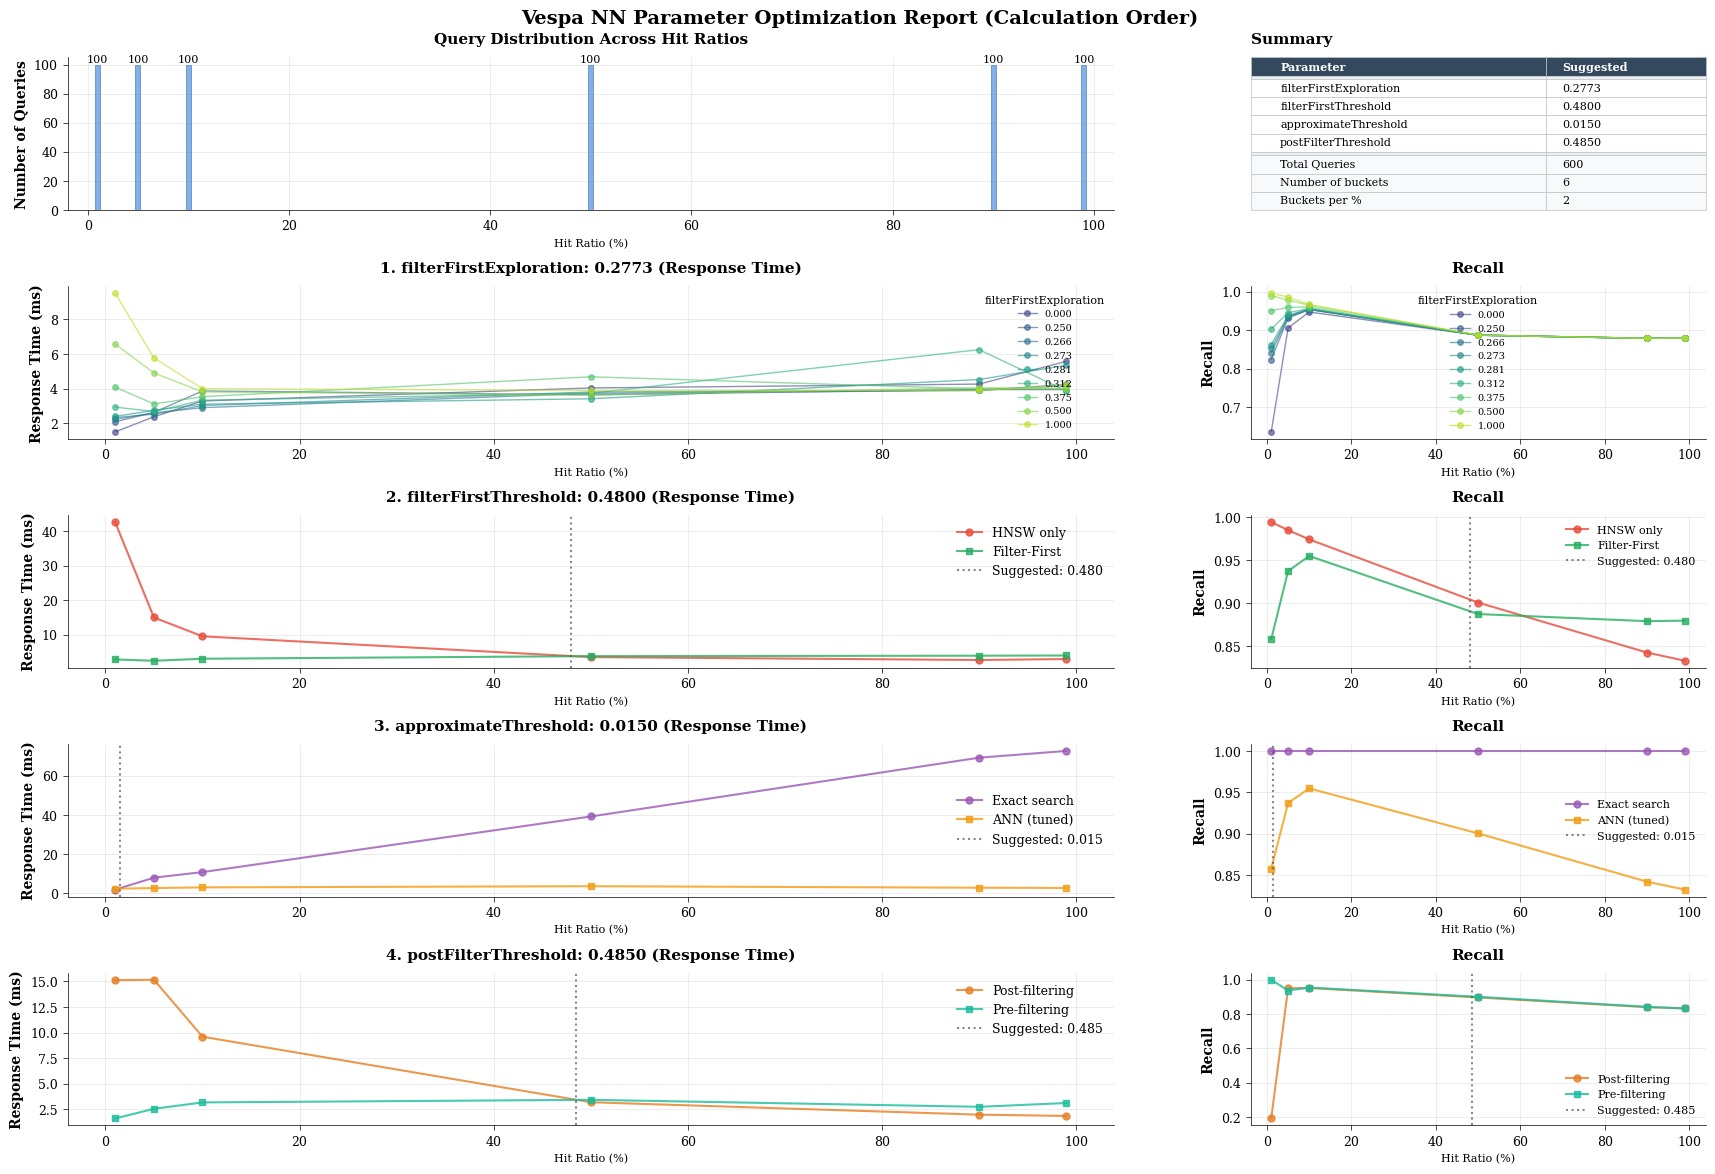

In [51]:
# Generate the visualization
fig = plot_optimization_report(report, figsize=(18, 12))
plt.show()

## Analyzing the report

Now, let us take a closer look at what this actually tells us.

If you prefer diving into the code yourself, feel free to expand the collapsed snippet below to see the steps of the `VespaNNParameterOptimizer.run()`-method.


In [24]:
from IPython.display import display, Markdown
import inspect

run_src = inspect.getsource(VespaNNParameterOptimizer.run)

display(
    Markdown(f"""
<details>
<summary>Click to see the code for the run-method</summary>

```python
{run_src}
```
</details>
""")
)


<details>
<summary>Click to see the code for the run-method</summary>

```python
    def run(self) -> Dict[str, Any]:
        """
        Determines suggestions for all parameters supported by this class.

        This method:
        1. Determines the hit-ratios of supplied ANN queries.
        2. Sorts these queries into buckets based on the determined hit-ratio.
        3. Determines a suggestion for filterFirstExploration.
        4. Determines a suggestion for filterFirstThreshold.
        5. Determines a suggestion for approximateThreshold.
        6. Determines a suggestion for postFilterThreshold.
        7. Reports the determined suggestions and all benchmarks and recall measurements performed.

        Returns:
            dict: A dictionary containing the suggested values, information about the query distribution, performed benchmarks, and recall measurements.

        Example:
            ```python
            {
                "buckets": {
                    "buckets_per_percent": 2,
                    "bucket_interval_width": 0.005,
                    "non_empty_buckets": [
                        2,
                        20,
                        100,
                        180,
                        190,
                        198
                    ],
                    "filtered_out_ratios": [
                        0.01,
                        0.1,
                        0.5,
                        0.9,
                        0.95,
                        0.99
                    ],
                    "hit_ratios": [
                        0.99,
                        0.9,
                        0.5,
                        0.09999999999999998,
                        0.050000000000000044,
                        0.010000000000000009
                    ],
                    "query_distribution": [
                        100,
                        100,
                        100,
                        100,
                        100,
                        100
                    ]
                },
                "filterFirstExploration": {
                    "suggestion": 0.39453125,
                    "benchmarks": {
                        "0.0": [
                            4.265999999999999,
                            4.256000000000001,
                            3.9430000000000005,
                            3.246999999999998,
                            2.4610000000000003,
                            1.768
                        ],
                        "1.0": [
                            3.9259999999999984,
                            3.6010000000000004,
                            3.290999999999999,
                            3.78,
                            4.927000000000002,
                            8.415000000000001
                        ],
                        "0.5": [
                            3.6299999999999977,
                            3.417,
                            3.4490000000000007,
                            3.752,
                            4.257,
                            5.99
                        ],
                        "0.25": [
                            3.5830000000000006,
                            3.616,
                            3.3239999999999985,
                            3.3200000000000016,
                            2.654999999999999,
                            2.3789999999999996
                        ],
                        "0.375": [
                            3.465,
                            3.4289999999999994,
                            3.196999999999997,
                            3.228999999999999,
                            3.167,
                            3.700999999999999
                        ],
                        "0.4375": [
                            3.9880000000000013,
                            3.463000000000002,
                            3.4650000000000007,
                            3.5000000000000013,
                            3.7499999999999982,
                            4.724000000000001
                        ],
                        "0.40625": [
                            3.4990000000000006,
                            3.3680000000000003,
                            3.147000000000001,
                            3.33,
                            3.381,
                            4.083999999999998
                        ],
                        "0.390625": [
                            3.6060000000000008,
                            3.5269999999999992,
                            3.2820000000000005,
                            3.433999999999998,
                            3.2880000000000007,
                            3.8609999999999984
                        ],
                        "0.3984375": [
                            3.6870000000000016,
                            3.386000000000001,
                            3.336000000000001,
                            3.316999999999999,
                            3.5329999999999973,
                            4.719000000000002
                        ]
                    },
                    "recall_measurements": {
                        "0.0": [
                            0.8758,
                            0.8768999999999997,
                            0.8915,
                            0.9489999999999994,
                            0.9045999999999998,
                            0.64
                        ],
                        "1.0": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9675999999999998,
                            0.9852999999999996,
                            0.9957999999999998
                        ],
                        "0.5": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9660999999999998,
                            0.9759999999999996,
                            0.9903
                        ],
                        "0.25": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9553999999999995,
                            0.9323999999999996,
                            0.8123000000000004
                        ],
                        "0.375": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9615999999999997,
                            0.9599999999999999,
                            0.9626000000000002
                        ],
                        "0.4375": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9642999999999999,
                            0.9697999999999999,
                            0.9832
                        ],
                        "0.40625": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9632,
                            0.9642999999999999,
                            0.9763999999999997
                        ],
                        "0.390625": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9625999999999999,
                            0.9617999999999999,
                            0.9688999999999998
                        ],
                        "0.3984375": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.963,
                            0.9635000000000001,
                            0.9738999999999999
                        ]
                    }
                },
                "filterFirstThreshold": {
                    "suggestion": 0.47,
                    "benchmarks": {
                        "hnsw": [
                            2.779,
                            2.725000000000001,
                            3.151999999999999,
                            7.138999999999998,
                            11.362,
                            32.599999999999994
                        ],
                        "filter_first": [
                            3.543999999999999,
                            3.454,
                            3.443999999999999,
                            3.4129999999999994,
                            3.4090000000000003,
                            4.602999999999998
                        ]
                    },
                    "recall_measurements": {
                        "hnsw": [
                            0.8284999999999996,
                            0.8368999999999996,
                            0.9007999999999996,
                            0.9740999999999996,
                            0.9852999999999993,
                            0.9937999999999992
                        ],
                        "filter_first": [
                            0.8757,
                            0.8768999999999997,
                            0.8909999999999999,
                            0.9627999999999999,
                            0.9630000000000001,
                            0.9718999999999994
                        ]
                    }
                },
                "approximateThreshold": {
                    "suggestion": 0.03,
                    "benchmarks": {
                        "exact": [
                            33.072,
                            31.99600000000001,
                            23.256,
                            9.155,
                            6.069000000000001,
                            2.0949999999999984
                        ],
                        "filter_first": [
                            2.9570000000000003,
                            2.91,
                            3.165000000000001,
                            3.396999999999998,
                            3.3310000000000004,
                            4.046
                        ]
                    },
                    "recall_measurements": {
                        "exact": [
                            1.0,
                            1.0,
                            1.0,
                            1.0,
                            1.0,
                            1.0
                        ],
                        "filter_first": [
                            0.8284999999999996,
                            0.8368999999999996,
                            0.9007999999999996,
                            0.9627999999999999,
                            0.9630000000000001,
                            0.9718999999999994
                        ]
                    }
                },
                "postFilterThreshold": {
                    "suggestion": 0.49,
                    "benchmarks": {
                        "post_filtering": [
                            2.0609999999999995,
                            2.448,
                            3.097999999999999,
                            7.200999999999999,
                            11.463000000000006,
                            11.622999999999996
                        ],
                        "filter_first": [
                            3.177999999999999,
                            2.717000000000001,
                            3.177,
                            3.5000000000000004,
                            3.455,
                            2.1159999999999997
                        ]
                    },
                    "recall_measurements": {
                        "post_filtering": [
                            0.8288999999999995,
                            0.8355,
                            0.8967999999999998,
                            0.9519999999999997,
                            0.9512999999999994,
                            0.19180000000000003
                        ],
                        "filter_first": [
                            0.8284999999999996,
                            0.8368999999999996,
                            0.9007999999999996,
                            0.9627999999999999,
                            0.9630000000000001,
                            1.0
                        ]
                    }
                }
            }
            ```
        """
        print("Distributing queries to buckets")
        # Distribute queries to buckets
        self.determine_hit_ratios_and_distribute_to_buckets(self.queries)

        # Check if the queries we have are deemed sufficient
        if not self.has_sufficient_queries():
            print(
                "  Warning: Selection of queries might not cover enough hit ratios to get meaningful results."
            )

        if not self.buckets_sufficiently_filled():
            print("  Warning: Only few queries for a specific hit ratio.")

        bucket_report = {
            "buckets_per_percent": self.buckets_per_percent,
            "bucket_interval_width": self.get_bucket_interval_width(),
            "non_empty_buckets": self.get_non_empty_buckets(),
            "filtered_out_ratios": self.get_filtered_out_ratios(),
            "hit_ratios": list(map(lambda x: 1 - x, self.get_filtered_out_ratios())),
            "query_distribution": self.get_query_distribution()[1],
        }
        if self.print_progress:
            print(bucket_report)

        # Determine filter-first parameters first
        # filterFirstExploration
        if self.print_progress:
            print("Determining suggestion for filterFirstExploration")
        filter_first_exploration_report = self.suggest_filter_first_exploration()
        filter_first_exploration = filter_first_exploration_report["suggestion"]
        if self.print_progress:
            print(filter_first_exploration_report)

        # filterFirstThreshold
        if self.print_progress:
            print("Determining suggestion for filterFirstThreshold")
        filter_first_threshold_report = self.suggest_filter_first_threshold(
            **{"ranking.matching.filterFirstExploration": filter_first_exploration}
        )
        filter_first_threshold = filter_first_threshold_report["suggestion"]
        if self.print_progress:
            print(filter_first_threshold_report)

        # approximateThreshold
        if self.print_progress:
            print("Determining suggestion for approximateThreshold")
        approximate_threshold_report = self.suggest_approximate_threshold(
            **{
                "ranking.matching.filterFirstThreshold": filter_first_threshold,
                "ranking.matching.filterFirstExploration": filter_first_exploration,
            }
        )
        approximate_threshold = approximate_threshold_report["suggestion"]
        if self.print_progress:
            print(approximate_threshold_report)

        # postFilterThreshold
        if self.print_progress:
            print("Determining suggestion for postFilterThreshold")
        post_filter_threshold_report = self.suggest_post_filter_threshold(
            **{
                "ranking.matching.approximateThreshold": approximate_threshold,
                "ranking.matching.filterFirstThreshold": filter_first_threshold,
                "ranking.matching.filterFirstExploration": filter_first_exploration,
            }
        )
        if self.print_progress:
            print(post_filter_threshold_report)

        report = {
            "buckets": bucket_report,
            "filterFirstExploration": filter_first_exploration_report,
            "filterFirstThreshold": filter_first_threshold_report,
            "approximateThreshold": approximate_threshold_report,
            "postFilterThreshold": post_filter_threshold_report,
        }

        return report

```
</details>


Now, let's inspect the plots, one by one. 

1. **Query Distribution Across Hit ratios:** 
   
   This plot simply shows how our queries are distributed across hit ratios. This is important to know, as the hit ratios are used to determine which ANN strategy is used. If for example we had a timestamp field, and all of our queries for a given use case included a filter that matched almost the whole timestamp range (ie. have *high hit ratios*), we could know that we won't benefit from tweaking the `approximateThreshold`-parameter, as it only affects queries with *very low hit ratios*. 
   
   _Note: For a real-world document-query set, you would not expect the distribution to be as evenly distributed as this._

2. **filterFirstExploration:**
   
   This plot shows the effect of tweaking filterFirstExploration. Decreasing it improves the response time at low hit ratios but also causes a drop in recall, and vice versa when the value is increased. Here, you probably want to choose a value that balances the two extremes.

3. **filterFirstThreshold:** 
   
   Here, we can see the effects of the set it to 0.00, i.e., disable it, we get a horrible spike in response time for queries with low hit ratios. On the other hand, we do not want to set it too high as this would result in a slight increase in response time.


4. **approximateThreshold:** 
   
   This plot shows when it makes sense to fall back to an exact search, i.e., for which hit ratios the exact search becomes cheaper than an approximative search. We want to set this to a value that is as large as possible while still offering acceptable response time. Note that the suggestion for this value may result in a lower recall than what is acceptable for your particular case. It should thus be interpreted merely as a suggestion.

5. **postFilterThreshold:** 
   
   The last plot shows the effect of enabling post-filtering. This offers a small benefit in terms of shorter response time when the hit-ratio is high. When the hit ratio gets smaller, the response time does not only spike with post-filtering, but the recall plummets.
   
   **Warning** _Do not_ set this too low, as this will cause degradation of quality (low recall)


Now, we can plot strategy across different hit ratios again, with the suggested parameters:

In [73]:
plot_src = inspect.getsource(plot_ann_strategy_selection)

display(
    Markdown(f"""
<details>
<summary>Click to see the plotting code</summary>

```python
{plot_src}
```
</details>
""")
)


<details>
<summary>Click to see the plotting code</summary>

```python
def plot_ann_strategy_selection(
    title: str = "ANN Strategy Selection Based on Hit Ratio",
    filter_first_threshold: float = 0.3,
    approximate_threshold: float = 0.02,
    post_filter_threshold: float = 1.0,
    figsize: tuple = (14, 6),
) -> plt.Figure:
    """
    Visualize which ANN strategy is selected across different hit ratios.

    Creates a plot showing the four strategy regions with colored backgrounds
    and annotated threshold values at switching points.

    Args:
        filter_first_threshold: Threshold for filter-first heuristic (default 0.3)
        approximate_threshold: Threshold for exact search fallback (default 0.02)
        post_filter_threshold: Threshold for post-filtering (default 1.0)
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object

    Example:
        >>> fig = plot_ann_strategy_selection(
        ...     filter_first_threshold=0.25,
        ...     approximate_threshold=0.03,
        ...     post_filter_threshold=0.95
        ... )
        >>> plt.show()
    """
    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Generate hit ratios from 0 to 1
    hit_ratios = np.linspace(0, 1, 1000)

    # Define strategy colors with transparency
    colors = {
        "Exact Search": "#9B59B6",
        "Filter-First/ACORN-1": "#27AE60",
        "HNSW with Pre-Filtering": "#3498DB",
        "Post-Filtering": "#E67E22",
    }

    # Calculate strategy for each hit ratio
    strategies = []
    for hr in hit_ratios:
        strategy = determine_ann_strategy(
            hr, filter_first_threshold, approximate_threshold, post_filter_threshold
        )
        strategies.append(strategy)

    # Plot colored regions for each strategy
    current_strategy = strategies[0]
    start_idx = 0

    for i in range(1, len(strategies)):
        if strategies[i] != current_strategy or i == len(strategies) - 1:
            end_idx = i if i < len(strategies) - 1 else i
            ax.axvspan(
                hit_ratios[start_idx] * 100,
                hit_ratios[end_idx] * 100,
                alpha=0.3,
                color=colors[current_strategy],
                label=current_strategy,
            )

            # Add text label in the middle of the region
            mid_point = (hit_ratios[start_idx] + hit_ratios[end_idx]) / 2 * 100
            ax.text(
                mid_point,
                0.5,
                current_strategy,
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
                color=colors[current_strategy],
                alpha=0.8,
            )

            current_strategy = strategies[i]
            start_idx = i

    # Add vertical lines and annotations at threshold points
    thresholds = [
        (approximate_threshold, "approximateThreshold", "left"),
        (filter_first_threshold, "filterFirstThreshold", "left"),
        (post_filter_threshold, "postFilterThreshold", "right"),
    ]

    for threshold, name, align in thresholds:
        if 0 < threshold <= 1.0:  # Only show if threshold is in valid range
            ax.axvline(
                x=threshold * 100,
                color="#2C3E50",
                linestyle="--",
                linewidth=2,
                alpha=0.8,
                zorder=10,
            )

            # Add annotation with parameter name and value
            y_pos = 0.85 if name == "filterFirstThreshold" else 0.95
            ax.annotate(
                f"{name}\n{threshold:.3f}",
                xy=(threshold * 100, y_pos),
                xytext=(10 if align == "left" else -10, 0),
                textcoords="offset points",
                ha=align,
                va="top",
                fontsize=9,
                fontweight="bold",
                bbox=dict(
                    boxstyle="round,pad=0.5",
                    facecolor="white",
                    edgecolor="#2C3E50",
                    linewidth=1.5,
                    alpha=0.9,
                ),
                arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=0",
                    lw=1.5,
                    color="#2C3E50",
                ),
            )

    # Set labels and title
    ax.set_xlabel("Hit Ratio (%)", fontsize=11, fontweight="bold")
    ax.set_ylabel("Strategy Selection", fontsize=11, fontweight="bold")
    ax.set_title(
        title,
        fontsize=13,
        fontweight="bold",
        pad=15,
    )

    # Remove y-axis ticks (not meaningful for this visualization)
    ax.set_yticks([])
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)

    # Style the axes
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(labelsize=9)
    ax.grid(True, axis="x", alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    plt.tight_layout()
    return

```
</details>


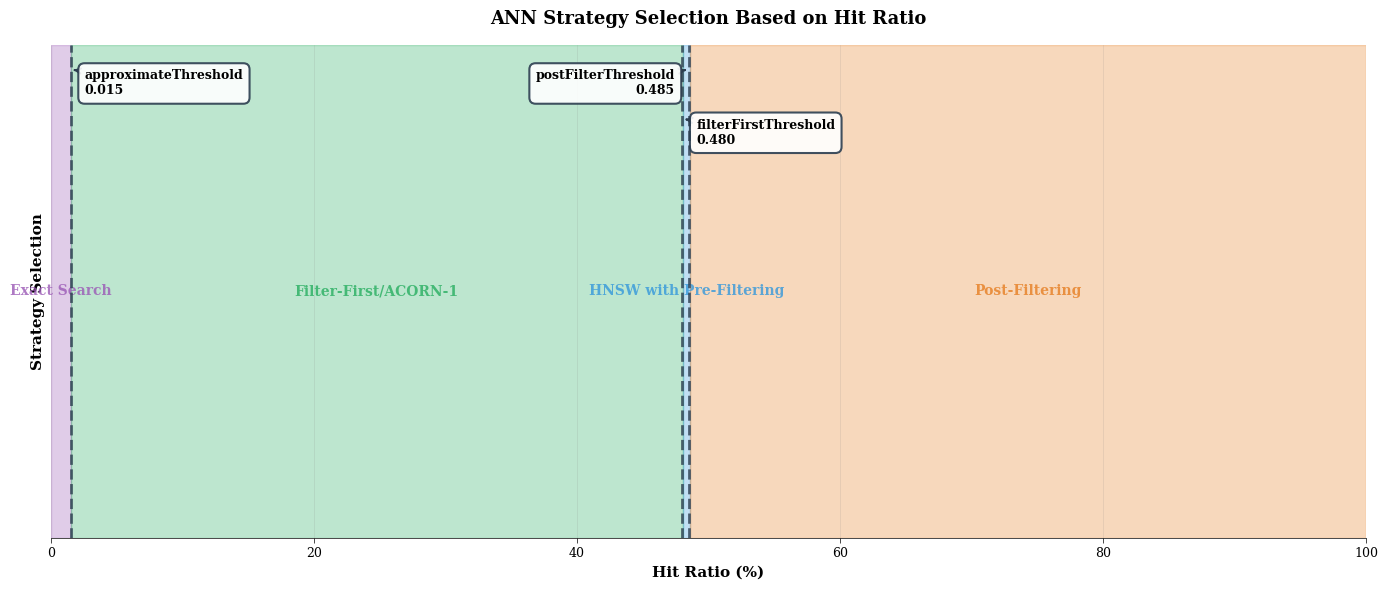

In [74]:
# with optimized parameters from report
fig = plot_ann_strategy_selection(
    filter_first_threshold=report["filterFirstThreshold"]["suggestion"],
    approximate_threshold=report["approximateThreshold"]["suggestion"],
    post_filter_threshold=report["postFilterThreshold"]["suggestion"],
)
plt.show()

## Comparing searchtime and recall

The next thing we want to do is to compare our suggested parameters against the default ones in terms of searchtime and recall. 

To do this, we will make use of the `VespaNNParameterOptimizer.benchmark()`-method.

This methods runs a set of queries, and calculates the recall (vs exact NN search) and collects the Vespa-reported `searchtime` for the queries per bucket of queries based on their hit ratio.

First, let us extract the suggested parameters, as returned in the report. 

In [27]:
def get_suggestions(report):
    suggested_parameters = {}
    prefix = "ranking.matching."
    for param, value in report.items():
        if "suggestion" in value:
            suggested_parameters[prefix + param] = value["suggestion"]
    return suggested_parameters


optimized_params = get_suggestions(report)

optimized_params

{'ranking.matching.filterFirstExploration': 0.27734375,
 'ranking.matching.filterFirstThreshold': 0.48,
 'ranking.matching.approximateThreshold': 0.015,
 'ranking.matching.postFilterThreshold': 0.485}

In [87]:
def run_benchmark(app: Vespa, params: dict = {}, queries=queries):
    # Create a new optimizer instance for step-by-step execution
    opt = VespaNNParameterOptimizer(
        app=app,
        queries=queries,
        hits=NUMBER_OF_HITS,
        buckets_per_percent=2,
        print_progress=True,
    )

    # Distribute queries to buckets
    opt.determine_hit_ratios_and_distribute_to_buckets(queries)

    bench_results = opt.benchmark(**params)
    recall_results = opt.compute_average_recalls(**params)
    return bench_results, recall_results


default_params = {
    "ranking.matching.filterFirstExploration": 0.3,
    "ranking.matching.filterFirstThreshold": 0.3,
    "ranking.matching.approximateThreshold": 0.02,
    "ranking.matching.postFilterThreshold": 1.00,
}
searchtime_before, recall_before = run_benchmark(app, default_params, queries)
searchtime_after, recall_after = run_benchmark(app, optimized_params, queries)

  Benchmarking: 100.0%
  Computing recall: 100.0%
  Benchmarking: 100.0%
  Computing recall: 100.0%


In [88]:
from typing import Tuple


def plot_benchmark_comparison(
    benchmark_data_1: dict,
    recall_data_1: dict,
    benchmark_data_2: dict,
    recall_data_2: dict,
    label_1: str = "Before",
    label_2: str = "After",
    title: str = "Benchmark Comparison",
    figsize: Tuple[int, int] = (14, 10),
) -> plt.Figure:
    """
    Create a visualization comparing two sets of benchmark and recall results.

    Each dataset is shown in its own row of subplots, with consistent y-axis
    scales for direct comparison.

    Args:
        benchmark_data_1: First dictionary containing searchtime statistics
        recall_data_1: First dictionary containing recall statistics
        benchmark_data_2: Second dictionary containing searchtime statistics
        recall_data_2: Second dictionary containing recall statistics
        label_1: Label for the first dataset (default: "Before")
        label_2: Label for the second dataset (default: "After")
        title: Title for the plot
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Extract data
    hit_ratios = np.array(benchmark_data_1["filtered_out_ratios"]) * 100

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Extract statistics
    stats_1 = benchmark_data_1["statistics"]
    stats_2 = benchmark_data_2["statistics"]
    recall_stats_1 = recall_data_1["statistics"]
    recall_stats_2 = recall_data_2["statistics"]

    # Calculate y-axis limits for consistent scaling
    # Search time limits (across both datasets)
    all_searchtime_values = []
    for stats in [stats_1, stats_2]:
        all_searchtime_values.extend(stats["mean"])
        all_searchtime_values.extend(stats["median"])
        all_searchtime_values.extend(stats["p95"])
        all_searchtime_values.extend(stats["p99"])

    searchtime_min = min(all_searchtime_values)
    searchtime_max = max(all_searchtime_values)
    searchtime_margin = (searchtime_max - searchtime_min) * 0.1
    searchtime_ylim = (
        max(0, searchtime_min - searchtime_margin),
        searchtime_max + searchtime_margin,
    )

    # Recall limits (should be 0-1.05)
    recall_ylim = (0, 1.05)

    # Define colors for each metric
    colors = {
        "mean": "#2C3E50",
        "median": "#3498DB",
        "p95": "#E74C3C",
        "p99": "#E67E22",
    }

    # Row 1: Dataset 1 (Before/Baseline)
    # Search Time
    ax_st_1 = axes[0, 0]
    ax_st_1.plot(
        hit_ratios,
        stats_1["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_st_1.plot(
        hit_ratios,
        stats_1["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_st_1.plot(
        hit_ratios,
        stats_1["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_st_1.plot(
        hit_ratios,
        stats_1["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_st_1.axhline(
        y=benchmark_data_1["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_st_1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_st_1.set_ylabel("Search Time (ms)", fontsize=10, fontweight="bold")
    ax_st_1.set_title(
        f"{label_1} - Search Time", fontsize=11, fontweight="bold", pad=10
    )
    ax_st_1.set_ylim(searchtime_ylim)
    ax_st_1.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_st_1)

    # Recall
    ax_rec_1 = axes[0, 1]
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_rec_1.axhline(
        y=recall_data_1["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_rec_1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_rec_1.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_rec_1.set_title(f"{label_1} - Recall", fontsize=11, fontweight="bold", pad=10)
    ax_rec_1.set_ylim(recall_ylim)
    ax_rec_1.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_rec_1)

    # Row 2: Dataset 2 (After/Optimized)
    # Search Time
    ax_st_2 = axes[1, 0]
    ax_st_2.plot(
        hit_ratios,
        stats_2["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_st_2.plot(
        hit_ratios,
        stats_2["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_st_2.plot(
        hit_ratios,
        stats_2["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_st_2.plot(
        hit_ratios,
        stats_2["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_st_2.axhline(
        y=benchmark_data_2["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_st_2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_st_2.set_ylabel("Search Time (ms)", fontsize=10, fontweight="bold")
    ax_st_2.set_title(
        f"{label_2} - Search Time", fontsize=11, fontweight="bold", pad=10
    )
    ax_st_2.set_ylim(searchtime_ylim)
    ax_st_2.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_st_2)

    # Recall
    ax_rec_2 = axes[1, 1]
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_rec_2.axhline(
        y=recall_data_2["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_rec_2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_rec_2.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_rec_2.set_title(f"{label_2} - Recall", fontsize=11, fontweight="bold", pad=10)
    ax_rec_2.set_ylim(recall_ylim)
    ax_rec_2.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_rec_2)

    # Overall title
    fig.suptitle(title, fontsize=13, fontweight="bold", y=0.995)
    plt.tight_layout()

    return fig

In [89]:
from IPython.display import display, Markdown
import inspect

plot_bench_src = inspect.getsource(plot_benchmark_comparison)

display(
    Markdown(f"""
<details>
<summary>Click to see the plotting code</summary>

```python
{plot_bench_src}
```
</details>
""")
)


<details>
<summary>Click to see the plotting code</summary>

```python
def plot_benchmark_comparison(
    benchmark_data_1: dict,
    recall_data_1: dict,
    benchmark_data_2: dict,
    recall_data_2: dict,
    label_1: str = "Before",
    label_2: str = "After",
    title: str = "Benchmark Comparison",
    figsize: Tuple[int, int] = (14, 10),
) -> plt.Figure:
    """
    Create a visualization comparing two sets of benchmark and recall results.

    Each dataset is shown in its own row of subplots, with consistent y-axis
    scales for direct comparison.

    Args:
        benchmark_data_1: First dictionary containing searchtime statistics
        recall_data_1: First dictionary containing recall statistics
        benchmark_data_2: Second dictionary containing searchtime statistics
        recall_data_2: Second dictionary containing recall statistics
        label_1: Label for the first dataset (default: "Before")
        label_2: Label for the second dataset (default: "After")
        title: Title for the plot
        figsize: Figure size as (width, height) tuple

    Returns:
        matplotlib Figure object
    """
    # Apply Tufte-inspired styling
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["axes.linewidth"] = 0.5
    plt.rcParams["xtick.major.width"] = 0.5
    plt.rcParams["ytick.major.width"] = 0.5

    def setup_tufte_axes(ax):
        """Apply minimal Tufte-style formatting to axes"""
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.tick_params(labelsize=9)
        ax.grid(True, alpha=0.2, linewidth=0.5, linestyle="-", color="gray")

    # Extract data
    hit_ratios = np.array(benchmark_data_1["filtered_out_ratios"]) * 100

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Extract statistics
    stats_1 = benchmark_data_1["statistics"]
    stats_2 = benchmark_data_2["statistics"]
    recall_stats_1 = recall_data_1["statistics"]
    recall_stats_2 = recall_data_2["statistics"]

    # Calculate y-axis limits for consistent scaling
    # Search time limits (across both datasets)
    all_searchtime_values = []
    for stats in [stats_1, stats_2]:
        all_searchtime_values.extend(stats["mean"])
        all_searchtime_values.extend(stats["median"])
        all_searchtime_values.extend(stats["p95"])
        all_searchtime_values.extend(stats["p99"])

    searchtime_min = min(all_searchtime_values)
    searchtime_max = max(all_searchtime_values)
    searchtime_margin = (searchtime_max - searchtime_min) * 0.1
    searchtime_ylim = (
        max(0, searchtime_min - searchtime_margin),
        searchtime_max + searchtime_margin,
    )

    # Recall limits (should be 0-1.05)
    recall_ylim = (0, 1.05)

    # Define colors for each metric
    colors = {
        "mean": "#2C3E50",
        "median": "#3498DB",
        "p95": "#E74C3C",
        "p99": "#E67E22",
    }

    # Row 1: Dataset 1 (Before/Baseline)
    # Search Time
    ax_st_1 = axes[0, 0]
    ax_st_1.plot(
        hit_ratios,
        stats_1["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_st_1.plot(
        hit_ratios,
        stats_1["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_st_1.plot(
        hit_ratios,
        stats_1["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_st_1.plot(
        hit_ratios,
        stats_1["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_st_1.axhline(
        y=benchmark_data_1["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_st_1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_st_1.set_ylabel("Search Time (ms)", fontsize=10, fontweight="bold")
    ax_st_1.set_title(
        f"{label_1} - Search Time", fontsize=11, fontweight="bold", pad=10
    )
    ax_st_1.set_ylim(searchtime_ylim)
    ax_st_1.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_st_1)

    # Recall
    ax_rec_1 = axes[0, 1]
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_rec_1.plot(
        hit_ratios,
        recall_stats_1["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_rec_1.axhline(
        y=recall_data_1["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_rec_1.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_rec_1.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_rec_1.set_title(f"{label_1} - Recall", fontsize=11, fontweight="bold", pad=10)
    ax_rec_1.set_ylim(recall_ylim)
    ax_rec_1.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_rec_1)

    # Row 2: Dataset 2 (After/Optimized)
    # Search Time
    ax_st_2 = axes[1, 0]
    ax_st_2.plot(
        hit_ratios,
        stats_2["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_st_2.plot(
        hit_ratios,
        stats_2["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_st_2.plot(
        hit_ratios,
        stats_2["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_st_2.plot(
        hit_ratios,
        stats_2["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_st_2.axhline(
        y=benchmark_data_2["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_st_2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_st_2.set_ylabel("Search Time (ms)", fontsize=10, fontweight="bold")
    ax_st_2.set_title(
        f"{label_2} - Search Time", fontsize=11, fontweight="bold", pad=10
    )
    ax_st_2.set_ylim(searchtime_ylim)
    ax_st_2.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_st_2)

    # Recall
    ax_rec_2 = axes[1, 1]
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["mean"],
        "o-",
        color=colors["mean"],
        linewidth=2,
        markersize=6,
        label="Mean",
        zorder=10,
    )
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["median"],
        "s-",
        color=colors["median"],
        linewidth=1.5,
        markersize=5,
        label="Median",
        alpha=0.8,
    )
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["p95"],
        "^-",
        color=colors["p95"],
        linewidth=1.5,
        markersize=5,
        label="P95",
        alpha=0.8,
    )
    ax_rec_2.plot(
        hit_ratios,
        recall_stats_2["p99"],
        "v-",
        color=colors["p99"],
        linewidth=1.5,
        markersize=5,
        label="P99",
        alpha=0.8,
    )
    ax_rec_2.axhline(
        y=recall_data_2["summary"]["overall_mean"],
        color=colors["mean"],
        linestyle=":",
        linewidth=1,
        alpha=0.4,
    )

    ax_rec_2.set_xlabel("Hit Ratio (%)", fontsize=10, fontweight="bold")
    ax_rec_2.set_ylabel("Recall", fontsize=10, fontweight="bold")
    ax_rec_2.set_title(f"{label_2} - Recall", fontsize=11, fontweight="bold", pad=10)
    ax_rec_2.set_ylim(recall_ylim)
    ax_rec_2.legend(fontsize=8, frameon=False, loc="best")
    setup_tufte_axes(ax_rec_2)

    # Overall title
    fig.suptitle(title, fontsize=13, fontweight="bold", y=0.995)
    plt.tight_layout()

    return fig

```
</details>


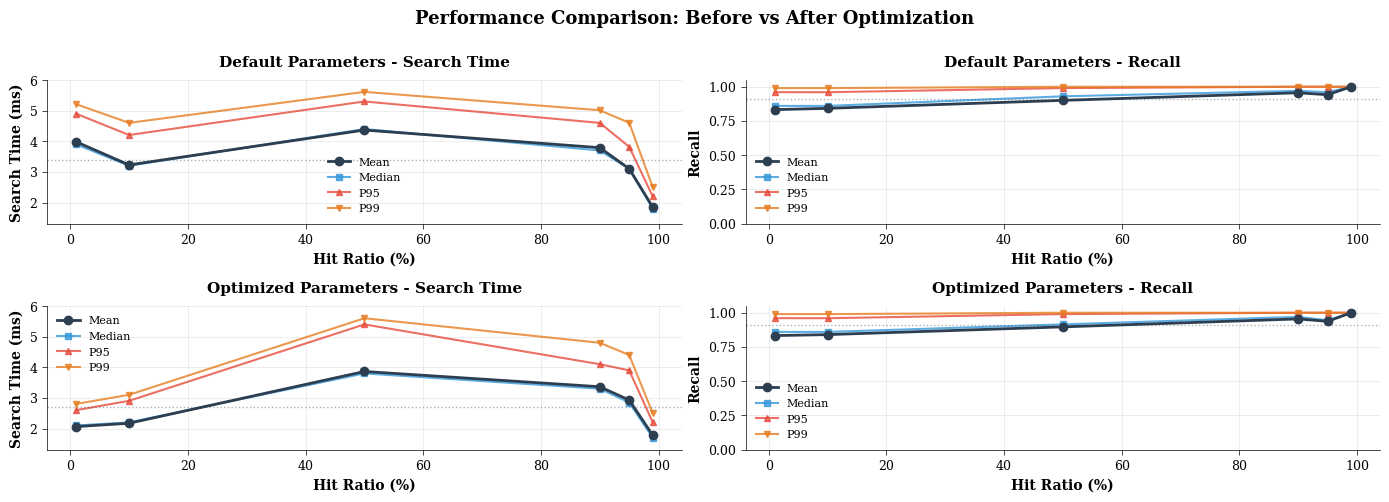

In [90]:
# Compare before and after optimization
fig = plot_benchmark_comparison(
    benchmark_data_1=searchtime_before.to_dict(),
    recall_data_1=recall_before.to_dict(),
    benchmark_data_2=searchtime_after.to_dict(),
    recall_data_2=recall_after.to_dict(),
    label_1="Default Parameters",
    label_2="Optimized Parameters",
    title="Performance Comparison: Before vs After Optimization",
    figsize=(14, 5),
)
plt.show()

In [91]:
import pandas as pd
from typing import Tuple


def calculate_metric_diff(
    after_dict: dict, before_dict: dict
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate differences between after and before metrics (searchtime or recall).

    Works for both searchtime (where lower is better) and recall (where higher is better).

    Args:
        after_dict: Dictionary containing metrics after optimization
        before_dict: Dictionary containing metrics before optimization

    Returns:
        Tuple of (df_stats, df_summary) DataFrames with absolute differences and percentage changes
    """
    # Extract hit ratios (same for both)
    hit_ratios = after_dict["filtered_out_ratios"]
    metric_name = after_dict.get("metric_name", "metric")

    # Create DataFrame for statistics
    stats_data = []
    for stat_name in ["mean", "median", "p95", "p99"]:
        after_values = np.array(after_dict["statistics"][stat_name])
        before_values = np.array(before_dict["statistics"][stat_name])

        abs_diff = after_values - before_values
        pct_change = ((after_values - before_values) / before_values) * 100

        for i, hr in enumerate(hit_ratios):
            stats_data.append(
                {
                    "hit_ratio": hr,
                    "statistic": stat_name,
                    "before": before_values[i],
                    "after": after_values[i],
                    "abs_diff": abs_diff[i],
                    "pct_change": pct_change[i],
                }
            )

    df_stats = pd.DataFrame(stats_data)

    # Create DataFrame for summary statistics
    summary_data = []
    for metric in ["overall_mean", "overall_median"]:
        before_val = before_dict["summary"][metric]
        after_val = after_dict["summary"][metric]
        abs_diff = after_val - before_val
        pct_change = ((after_val - before_val) / before_val) * 100

        summary_data.append(
            {
                "metric": metric,
                "before": before_val,
                "after": after_val,
                "abs_diff": abs_diff,
                "pct_change": pct_change,
            }
        )

    df_summary = pd.DataFrame(summary_data)

    # Add metric name to both dataframes for clarity
    df_stats["metric_name"] = metric_name
    df_summary["metric_name"] = metric_name

    return df_stats, df_summary


# Calculate differences for searchtime
searchtime_stats, searchtime_summary = calculate_metric_diff(
    searchtime_after.to_dict(), searchtime_before.to_dict()
)

# Calculate differences for recall
recall_stats, recall_summary = calculate_metric_diff(
    recall_after.to_dict(), recall_before.to_dict()
)
searchtime_stats

,hit_ratio,statistic,before,after,abs_diff,pct_change,metric_name
0,0.01,mean,3.984,2.063,-1.921,-48.217871,searchtime
1,0.10,mean,3.228,2.173,-1.055,-32.682776,searchtime
2,0.50,mean,4.367,3.863,-0.504,-11.541104,searchtime
3,0.90,mean,3.791,3.365,-0.426,-11.237141,searchtime
4,0.95,mean,3.105,2.930,-0.175,-5.636071,searchtime
5,0.99,mean,1.851,1.782,-0.069,-3.727715,searchtime
6,0.01,median,3.900,2.100,-1.800,-46.153846,searchtime
7,0.10,median,3.200,2.200,-1.000,-31.250000,searchtime
8,0.50,median,4.400,3.800,-0.600,-13.636364,searchtime
9,0.90,median,3.700,3.300,-0.400,-10.810811,searchtime


We can see that the searchtimes improve with the suggested parameters.

Now, let us take a look at the recall stats:

In [92]:
recall_stats

,hit_ratio,statistic,before,after,abs_diff,pct_change,metric_name
0,0.01,mean,0.8328,0.8333,0.0005,0.060038,recall
1,0.10,mean,0.8424,0.8403,-0.0021,-0.249288,recall
2,0.50,mean,0.9006,0.8968,-0.0038,-0.421941,recall
3,0.90,mean,0.9559,0.9548,-0.0011,-0.115075,recall
4,0.95,mean,0.9417,0.9372,-0.0045,-0.477859,recall
5,0.99,mean,1.0000,1.0000,0.0000,0.000000,recall
6,0.01,median,0.8600,0.8600,0.0000,0.000000,recall
7,0.10,median,0.8600,0.8600,0.0000,0.000000,recall
8,0.50,median,0.9300,0.9150,-0.0150,-1.612903,recall
9,0.90,median,0.9700,0.9700,0.0000,0.000000,recall


We can see that the tradeoff for the reduced latencies are a small reduction in recall. 

## Conclusion and next steps

We have provided example code and hopefully some intuiton that you can use to optimize the ANN-search for your own applications. 

We want to emphasize that there is no "correct" choice of value for these parameters, as it will always be about balancing tradeoffs. Please try to understand the report to help you make the right choices for your requirements, rather than to blindly accept the suggestions.

Tuning the parameters that determine the ANN-strategy is helpful to reduce the latency of some of your most "problematic" queries, as they are likely to suffer from a suboptimal strategy.

It is wise to log and add these high latency queries to you query set in order to improve them. 

Make sure that they actually are high-latency queries by rerunning them, to verify they were not just issued at a time your application is under heavy load.

Also, don't forget to include a representative sample of your other queriesfor the optimization as well, to make sure that you don't just switch strategy at the cost of other queries.

If you are willing to trade even less recall for faster searchtimes, you could reduce the [targetHits](https://docs.vespa.ai/en/nearest-neighbor-search.html#querying-using-nearestneighbor-query-operator)-parameter passed to the [nearestNeighbor](https://docs.vespa.ai/en/reference/query-language-reference.html#nearestneighbor)-query operator. (Or increase it if you want more recall at the cost of higher latencies).

Now that you have tuned your ANN-parameters for recall and performance, consider doing quality evaluation. 

Take a look at the [Evaluating a Vespa application](https://vespa-engine.github.io/pyvespa/evaluating-vespa-application-cloud.html)-notebook for some tips on getting started. 

## FAQ

**Q: When should I consider re-tuning the ANN-parameters?**

If either your corpus or your query load changes so that the typical hit ratios for your queries change.

**Q: Will this tuning guarantee low latency across all queries?**

No, but if you observe queries with high-latency, consider adding these queries to your tuning queries, and rerun the optimization to ensure these queries are accounted for. 

**Q: What if I observe poor recall for some ANN queries?** 

Consider increasing your `filterfirstExploration` value. Note that this comes at a cost of latency. 

**Q: I have questions about my ANN parameter choices**

Please generate the report as shown in this notebook for your application and queries, and reach out to us in our [community slack](https://slack.vespa.ai/). 

This will allow us to help you much more easily.

### Delete application

The following will delete the application and data from the dev environment.

In [93]:
if os.getenv("CI") == "true":
    vespa_cloud.delete()